In [45]:
import hashlib
import json
from datetime import datetime, timedelta
import random


# tạo một block
class Block:
    def __init__(self,data) :
        self.data = data
        self.prev_hash = ""
        self.nonce = 0
        self.hash = ""
        self.total_time = ""

# tạo hàm băm data với thuật toán sha512
def hash(block):
    data = json.dumps(block.data) + block.prev_hash + str(block.nonce)
    data = data.encode('utf-8')
    return hashlib.sha256(data).hexdigest()
# tạo blockchain la chuoi cac block
class Blockchain:
    def __init__(self,miner) :
        self.miner = miner
        self.chain = [] # genesis block
        self.reward = 5  # Phần thưởng ban đầu
        self.halving_interval = 2000  # Số block giảm phần thưởng


        genesis_block = Block("Geneis Block")
        genesis_block.hash = hash(genesis_block)

        self.chain.append(genesis_block)

    def get_block_subsidy(self, height):
        halvings = height // self.halving_interval
        # Force block reward to zero when right shifting is undefined.
        if halvings >= 64:
            return 0

        # Subsidy is cut in half every halving interval
        n_subsidy = self.reward / (2 ** halvings)
        return float(n_subsidy)


    def add_block(self, data):
         # Kiểm tra giới hạn số lượng token trong một giao dịch
        for transaction in data:
            if transaction["amount"] > 999999:
                print("Transaction amount exceeds the limit (999.999). Block not added.")
                return

        total_transactions = len(data)
        block=Block(data)

        block.data.append({"from":"", "to": self.miner, "amount": self.get_block_subsidy(len(self.chain) - 1) + total_transactions}) # thưởng cho miner khi mã hóa được block

        block.prev_hash = self.chain[-1].hash
        block.hash = hash(block)
        start = datetime.now()  # bắt đầu đếm time
        elapsed_time = timedelta()
        while not hash(block).startswith("0") or elapsed_time < timedelta(seconds=0): # ham kiem tra do kho và thời gian cho miner, ví dụ tăng độ khó lên "0xabcd",thời gian lên ít nhất 2 phút 1 block
            block.nonce += 1
            block.hash = hash(block)
            elapsed_time = datetime.now() - start
        end = datetime.now()  # ket thuc đếm time
        block.total_time = str(end-start)

        # Kiểm tra số dư của mỗi tài khoản
        if not self.is_balance_valid():
            return
        #  Kiểm tra tổng số token của tất cả các tài khoản và miner
        elif not self.sum_balance_valid():
            return
        else:
            self.chain.append(block)


    def print(self):
      chain_number = 1

      # duyet cac phan tu trong list
      for block in self.chain:
          print('Block number:', chain_number)
          print("Data:", block.data)
          print("Previous hash:", block.prev_hash)
          print("Hash:", block.hash)
          print("Nonce:", block.nonce)
          print("Total time:", block.total_time)
          print("-------------------------------------------------------------------------------------------------------")
          print("")
          chain_number += 1
    def is_valid(self):
        for i in range(1, len(self.chain)):

            current_block = self.chain[i]
            prev_block =  self.chain[i-1]

            if hash(current_block) != current_block.hash:
                return False
            if prev_block.hash != current_block.prev_hash:
                return False
            # check thêm điều kiện
        return True
    def sum_balance_valid(self):
        sum=0
        accounts = set()
        for block in self.chain:
            if isinstance(block.data, list):
                for transaction in block.data:
                    accounts.add(transaction["from"])
                    accounts.add(transaction["to"])
                accounts.discard("")
        for account in accounts:
            balance = self.get_balance(account)
            sum = sum + balance
        if sum >1000000:
                print("Sum of all tokens exceeds the limit (1.000.000). Block not added.")
                self.chain.pop()
                return False
        return True

    def is_balance_valid(self):
        accounts = set()
        for block in self.chain:
            if isinstance(block.data, list):
                for transaction in block.data:
                    accounts.add(transaction["from"])
                    accounts.add(transaction["to"])
                accounts.discard("")
        for account in accounts:

            balance = self.get_balance(account)
            # Kiểm tra số dư của mỗi tài khoản
            if not (0 <= balance <= 1000000):
                print(f"Balance of {account} ({balance} CTC) is not within the valid range (0, 1.000.000). Block not added.")
                self.chain.pop()
                return False
        return True

    def get_balance(self,person):
        balance = 0  # số dư
        for block in self.chain:
            if type(block.data) != list :
                continue
            for transfer in block.data :
                if transfer["from"] == person:   # nếu chuyển đi thì bị trừ tiền
                    balance = balance -transfer["amount"] - random.uniform(0.1, 1)
                if transfer["to"] == person:   # nếu nhận vào thì + tiền
                    balance = balance +transfer["amount"]
        return balance
    def print_all_accounts(self):
        accounts = set()
        total_token = 0
        for block in self.chain:
            if isinstance(block.data, list):
                for transaction in block.data:
                    accounts.add(transaction["from"])
                    accounts.add(transaction["to"])
                accounts.discard("")
        for account in accounts:
            balance = self.get_balance(account)
            total_token = total_token + balance
        account_balances = {account: self.get_balance(account) for account in accounts}
        sorted_account_balances = sorted(account_balances.items(), key=lambda item: item[1], reverse=True)
        print("All Accounts:")
        print(f"Total Token: {total_token} CTC")
        for account, balance in sorted_account_balances:
            print(f"  {account}: {balance} CTC")
        print("-------------------------------------------------------------------------------------------------------")
    def get_accounts(self):
      accounts = set()
      for block in self.chain:
          if isinstance(block.data, list):
              for transaction in block.data:
                  accounts.add(transaction["from"])
                  accounts.add(transaction["to"])
              accounts.discard("")
      return accounts
    def stake_in_pool(self, pool_number,account_name,stake_amount):
      if pool_number not in {1, 2, 3}:
          print("Invalid pool number.")
          return
      locked_period = 0
      staking_fee = 0

      if pool_number == 1:
          locked_period = 3  # tháng
          staking_fee = 5
      elif pool_number == 2:
          locked_period = 6  # tháng
          staking_fee = 10
      elif pool_number == 3:
          locked_period = 12  # tháng
          staking_fee = 15
      # Kiểm tra số dư của tài khoản trước khi thêm stake
      if not (0 <= stake_amount <= 1000000):
          print("Stake amount is not within the valid range (0, 1.000.000). Stake not added.")
          return

      # Kiểm tra số dư của tài khoản
      if not self.is_balance_valid():
          return

      # Kiểm tra tổng số token của tất cả các tài khoản và miner
      elif not self.sum_balance_valid():
          return
      else:
          # Thêm giao dịch stake vào block
          stake_transaction = {"from": account_name, "to": f"Pool {pool_number}", "amount": stake_amount}
          fee_transaction = {"from": account_name, "to": "", "amount": staking_fee}
          self.add_block([stake_transaction, fee_transaction])

          # Xử lý lãi và phí staking
          locked_time = datetime.now() + timedelta(seconds=locked_period)
          print(f"Stake successful in Pool {pool_number}. Locked until {locked_time.strftime('%Y-%m-%d %H:%M:%S')}.")
          print("Interest will be calculated upon maturity.")
          print(f"Staking fee: {staking_fee} CTC deducted from your account.")
          print("-------------------------------------------------------------------------------------------------------")
          return locked_time

    def withdraw_stake(self, pool_number, locked_time,account_name,stake_amount):
        if pool_number not in {1, 2, 3}:
            print("Invalid pool number.")
            return
        withdraw_fee = 1
        current_time = datetime.now()
        if isinstance(locked_time, str):
          locked_time = datetime.strptime(locked_time, '%Y-%m-%d %H:%M:%S')
        if current_time < locked_time:
            print("Stake is still locked. Cannot withdraw before the lock period.")
        else:
            # Tính toán lãi và trả về tài khoản
            interest_earned = self.calculate_interest(locked_time, current_time, pool_number,stake_amount)
            withdrawal_amount = stake_amount
            # Thêm giao dịch rút stake và lãi vào block
            withdrawal_transaction = {"from": f"Pool {pool_number}", "to": account_name, "amount": withdrawal_amount-withdraw_fee}
            interest_transaction = {"from": "", "to": account_name, "amount": interest_earned-withdraw_fee}
            self.add_block([withdrawal_transaction, interest_transaction])

            print(f"Withdrawal successful from Pool {pool_number}.")
            print(f"Stake amount: {withdrawal_amount} CTC")
            print(f"Interest earned: {interest_earned} CTC")
            print("-------------------------------------------------------------------------------------------------------")

    def calculate_interest(self, start_time, end_time, pool_number,stake_amount):
        # Tính toán lãi dựa trên thời gian và lãi suất của pool
        time_diff = end_time - start_time
        locked_period = 0
        interest_rate = 0

        if pool_number == 1:
            locked_period = 3  # tháng
            interest_rate = 0.03  # 3%
        elif pool_number == 2:
            locked_period = 6  # tháng
            interest_rate = 0.08  # 8%
        elif pool_number == 3:
            locked_period = 12  # tháng
            interest_rate = 0.2  # 20%

         # Chuyển đổi chênh lệch thời gian sang đơn vị giây
        seconds_diff = time_diff.total_seconds()
        if seconds_diff - locked_period < 0:
            return 0  # Không tìm thấy thông tin giao dịch stake
        interest_earned = stake_amount * interest_rate
        return interest_earned
    def choose_pool(self):
        print("Choose a staking pool:")
        print("1. Pool 1 - Limit: 50000 tokens, Lock period: 3 months, Interest: 3%, Staking fee: 5")
        print("2. Pool 2 - Limit: 10000 tokens, Lock period: 6 months, Interest: 8%, Staking fee: 10")
        print("3. Pool 3 - Limit: 4000 tokens, Lock period: 12 months, Interest: 20%, Staking fee: 15")
        staking_fee = 0

        while True:
            try:
                pool_number = int(input("Enter the pool number (1, 2, or 3): "))
                account_name = input("Enter account name for staking: ")
                stake_amount = float(input("Enter the stake amount: "))
                
                # Set the maximum limit for each pool
                max_limit = {1: 50000, 2: 10000, 3: 4000}
                
                if pool_number in {1, 2, 3} and stake_amount <= max_limit[pool_number]:
                    if pool_number == 1:
                        staking_fee = 5
                    elif pool_number == 2:
                        staking_fee = 10
                    elif pool_number == 3:
                        staking_fee = 15

                    stake_amount = stake_amount - staking_fee
                    return pool_number, account_name, stake_amount
                else:
                    print(f"Invalid stake amount. Please enter a value less than or equal to {max_limit[pool_number]}.")
            except ValueError:
                print("Invalid input. Please enter a valid number.")
    def has_staked(self, account_name, pool_number):
      for block in self.chain:
          if isinstance(block.data, list):
              for transaction in block.data:
                  if transaction["from"] == account_name and transaction["to"] == f"Pool {pool_number}":
                      return True
      return False

    def get_stake_info(self, account_name, pool_number):
        for block in reversed(self.chain):
            if isinstance(block.data, list):
                for transaction in block.data:
                    if transaction["from"] == account_name and transaction["to"] == f"Pool {pool_number}":
                        return  transaction["amount"]
        return 0





In [46]:
blockchain = Blockchain("Miner")

  # Đọc dữ liệu từ file JSON
with open('DATA.json', 'r') as json_file:
        DATA = json.load(json_file)

  # Thêm block từ dữ liệu JSON vào blockchain
for block_transactions in DATA:
        if blockchain.is_balance_valid() == False:
            break
        else:
            blockchain.add_block(block_transactions)


In [47]:
blockchain.print_all_accounts()

All Accounts:
Total Token: 330694.177489083 CTC
  Miner: 44157.46875 CTC
  OKX Coder: 18484.461824744925 CTC
  FTX Coder: 18218.033018928978 CTC
  Binance Coder: 18175.389622048744 CTC
  Bybit Coder: 18163.519967990564 CTC
  MM Coder: 18099.503749222713 CTC
  Kucoin Coder: 18091.428721369277 CTC
  Exchange Coder: 18064.944779273697 CTC
  Kraden Coder: 18004.576021795725 CTC
  Coinbase Coder: 17985.46455840904 CTC
  Dev Coder: 17781.220151708276 CTC
  Thanh Bao Coder: 10776.294821508563 CTC
  Nhi Coder: 10736.84003720654 CTC
  Anh Coder: 10735.759531509395 CTC
  Chinh Coder: 10690.08243412298 CTC
  Nguyen Coder: 10663.638346207097 CTC
  Thuong Coder: 10613.386962859819 CTC
  Sai Coder: 10384.536239686804 CTC
  Yen Coder: 10370.353143748156 CTC
  Van Coder: 10281.788472615668 CTC
  Thai Coder: 10140.025558111198 CTC
-------------------------------------------------------------------------------------------------------


In [48]:

blockchain.print() 

Block number: 1
Data: Geneis Block
Previous hash: 
Hash: 4a18a3ed4794e248b7bcefb5fca3bcf07f47d8f8a562483193d876fe63f63c00
Nonce: 0
Total time: 
-------------------------------------------------------------------------------------------------------

Block number: 2
Data: [{'from': '', 'to': 'Dev Coder', 'amount': 30000}, {'from': '', 'to': 'MM Coder', 'amount': 30000}, {'from': '', 'to': 'Exchange Coder', 'amount': 30000}, {'from': '', 'to': 'Coinbase Coder', 'amount': 30000}, {'from': '', 'to': 'Binance Coder', 'amount': 30000}, {'from': '', 'to': 'OKX Coder', 'amount': 30000}, {'from': '', 'to': 'Bybit Coder', 'amount': 30000}, {'from': '', 'to': 'FTX Coder', 'amount': 30000}, {'from': '', 'to': 'Kraden Coder', 'amount': 30000}, {'from': '', 'to': 'Kucoin Coder', 'amount': 30000}, {'from': '', 'to': 'Miner', 'amount': 15.0}]
Previous hash: 4a18a3ed4794e248b7bcefb5fca3bcf07f47d8f8a562483193d876fe63f63c00
Hash: 0952d70a4c76127738a6d95a07ef60e64ea2dec2a51f25ddad456afeb8a41134
Nonce: 11
T

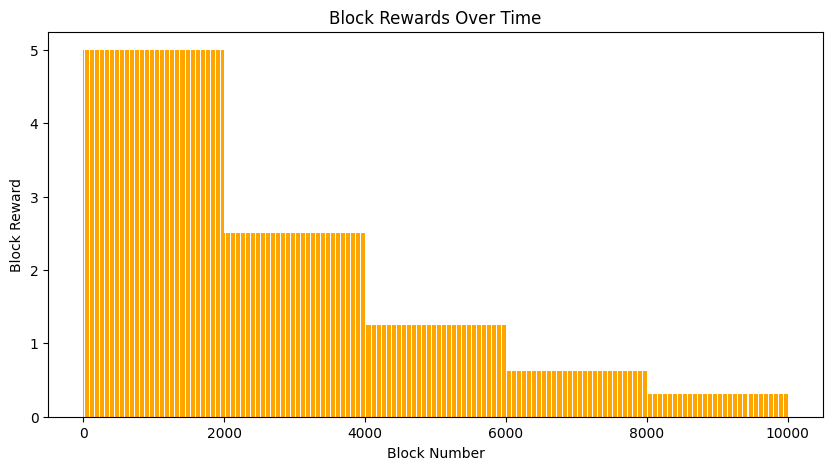

In [50]:
import matplotlib.pyplot as plt
import random

admin_names = ["Dev Coder", "MM Coder", "Exchange Coder", "Coinbase Coder", "Binance Coder", "OKX Coder", "Bybit Coder", "FTX Coder", "Kraden Coder", "Kucoin Coder",]
account_names = ["Thanh Bao Coder", "Chinh Coder", "Sai Coder", "Nguyen Coder", "Nhi Coder", "Van Coder", "Thai Coder", "Yen Coder", "Thuong Coder", "Anh Coder"]

# Tạo dữ liệu mẫu cho biểu đồ
blockchain_lengths = list(range(1, len(blockchain.chain) + 1))
block_rewards = [float(blockchain.get_block_subsidy(i)) for i in range(len(blockchain.chain))]
account_balances = [blockchain.get_balance(account) for account in account_names]

# Biểu đồ 2: Biểu đồ cột của thưởng block qua số lượng block
plt.figure(figsize=(10, 5))
plt.bar(blockchain_lengths, block_rewards, color='orange')
plt.title('Block Rewards Over Time')
plt.xlabel('Block Number')
plt.ylabel('Block Reward')

# Kiểm tra xem có giá trị nào trên trục tung không
yticks_values = plt.yticks()[0]

plt.show()



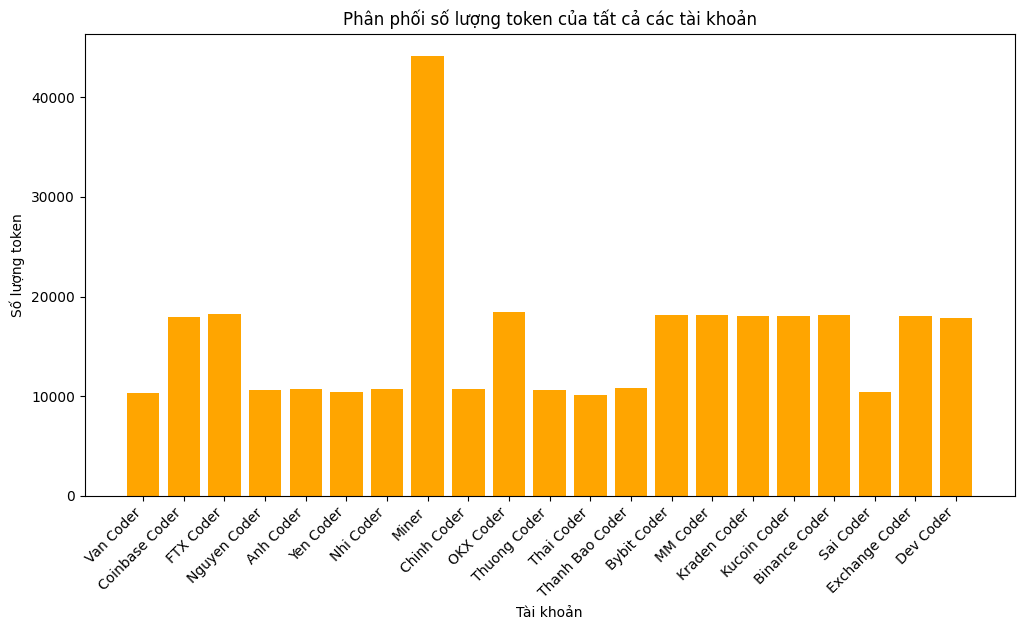

In [55]:
import matplotlib.pyplot as plt

def plot_token_distribution(blockchain):
    accounts = list(blockchain.get_accounts())  # Chuyển từ set sang list
    balances = [blockchain.get_balance(account) for account in accounts]

    plt.figure(figsize=(12, 6))
    plt.bar(accounts, balances, color='orange')  # Màu cam
    plt.title('Phân phối số lượng token của tất cả các tài khoản')
    plt.xlabel('Tài khoản')
    plt.ylabel('Số lượng token')
    plt.xticks(rotation=45, ha='right')
    plt.show()

# Sử dụng hàm để vẽ biểu đồ
plot_token_distribution(blockchain)


In [58]:
def main():
      
  blockchain.print_all_accounts()
  # print("Is valid :",blockchain.is_valid())
  print("----------------------------------------- STAKE TOKEN -------------------------------------------------")
  STAKE_INFO = []
  while True:
      print("\nOptions:")
      print("1. Stake")
      print("2. Withdraw")
      print("3. Quit")

      choice = input("Enter your choice (1, 2, or 3): ")
      if choice == "1":
            chosen_pool, account_name, stake_amount = blockchain.choose_pool()
            locked_time = blockchain.stake_in_pool(chosen_pool, account_name, stake_amount)
            if locked_time is not None:
                # Save stake information
                stake_info = {"account_name": account_name, "pool_number": chosen_pool, "locked_time": locked_time, "stake_amount": stake_amount}
                STAKE_INFO.append(stake_info)
                blockchain.print_all_accounts()
      elif choice == "2":
            account_name = input("Enter account name for withdrawing: ")
            pool_number = int(input("Enter the pool number (1, 2, or 3): "))
            
            stake_info = next((info for info in STAKE_INFO if info["account_name"] == account_name and info["pool_number"] == pool_number), None)
            # Check if the account has staked in the chosen pool
            if blockchain.has_staked(account_name, pool_number):
                    locked_time = stake_info["locked_time"]
                    stake_amount = stake_info["stake_amount"]
                    blockchain.withdraw_stake(pool_number, locked_time, account_name, stake_amount)
                    blockchain.print_all_accounts()
                    # Remove stake information after withdrawal
                    STAKE_INFO.remove(stake_info)
            else:
                print(f"{account_name} has not staked in Pool {pool_number}. Cannot withdraw.")
      elif choice == "3":
            print("Exiting program.")
            break
      else:
            print("Invalid choice. Please enter 1, 2, or 3.")
if __name__ == "__main__":
    main()


All Accounts:
Total Token: 330681.13864318334 CTC
  Miner: 44163.9375 CTC
  OKX Coder: 18515.74847103548 CTC
  FTX Coder: 18240.55890739467 CTC
  Bybit Coder: 18161.211064651576 CTC
  Binance Coder: 18158.5190090171 CTC
  Kucoin Coder: 18088.6335079212 CTC
  MM Coder: 18080.190998895163 CTC
  Exchange Coder: 18078.0227941641 CTC
  Coinbase Coder: 18014.228059050907 CTC
  Kraden Coder: 17984.94598328178 CTC
  Dev Coder: 15837.232330199526 CTC
  Thanh Bao Coder: 10776.837805877589 CTC
  Nhi Coder: 10736.84003720654 CTC
  Anh Coder: 10735.759531509395 CTC
  Chinh Coder: 10690.12672467904 CTC
  Nguyen Coder: 10663.638346207097 CTC
  Thuong Coder: 10613.386962859819 CTC
  Sai Coder: 10384.536239686804 CTC
  Yen Coder: 10370.353143748156 CTC
  Van Coder: 10281.788472615668 CTC
  Thai Coder: 10140.025558111198 CTC
  Pool 1: 1995.2487172811086 CTC
-------------------------------------------------------------------------------------------------------
----------------------------------------- ST